In [1]:
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from pathlib import Path

from enum import Enum

from sentinelhub import CRS, BBoxSplitter, BBox

from shapely.geometry import Polygon

from eolearn.io.local_io import *
from contextlib import contextmanager  

import rasterio
from rasterio import Affine, MemoryFile
from rasterio.enums import Resampling


# Imports from eo-learn and sentinelhub-py
from eolearn.core import EOTask, EOPatch, LinearWorkflow, FeatureType, OverwritePermission, \
    LoadFromDisk, SaveToDisk, EOExecutor
from eolearn.io import S2L1CWCSInput, ExportToTiff
from eolearn.mask import AddCloudMaskTask, get_s2_pixel_cloud_detector, AddValidDataMaskTask
from eolearn.geometry import VectorToRaster, PointSamplingTask, ErosionTask
from eolearn.features import LinearInterpolation, SimpleFilterTask, InterpolationTask, ValueFilloutTask, \
    HaralickTask
from sentinelhub import BBoxSplitter, BBox, CRS, CustomUrlParam

from tqdm import tqdm 


/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [11]:
data_path = Path('../data')
sentinel_path = data_path/'sentinel'

output_path = Path('output')
shape_path = output_path/Path('shape')
patch_path = output_path/Path('patch')

shape_path.mkdir(exist_ok=True, parents=True)

### Load shape file

In [3]:
train_test_gpdf = gpd.read_file(data_path/'train_test_shp')

In [4]:
orange_river_crs = CRS.UTM_34S
train_test_gpdf = train_test_gpdf.to_crs(crs={'init': CRS.ogc_string(orange_river_crs)})

### Create a buffer around union of all shapes

In [5]:
orange_river = train_test_gpdf.geometry.unary_union.buffer(400)

### Split the buffered zone into boxes

In [7]:
# Create the splitter to obtain a list of bboxes

bbox_splitter = BBoxSplitter([orange_river], orange_river_crs, (60,50), reduce_bbox_sizes=True)

bbox_list = np.array(bbox_splitter.get_bbox_list())
info_list = np.array(bbox_splitter.get_info_list())

# Create patchIDs
patchIDs = []
for idx, [bbox, info] in enumerate(zip(bbox_list, info_list)):
    patchIDs.append(idx)
    
# Prepare info of selected EOPatches
geometry = [Polygon(bbox.get_polygon()) for bbox in bbox_list[patchIDs]]
idxs_x = [info['index_x'] for info in info_list[patchIDs]]
idxs_y = [info['index_y'] for info in info_list[patchIDs]]

gdf = gpd.GeoDataFrame({'index_x': idxs_x, 'index_y': idxs_y}, 
                       crs={'init': CRS.ogc_string(orange_river_crs)}, 
                       geometry=geometry)

# save to shapefile
shapefile_name = shape_path/'selected_orange_river_bboxes.shp'
gdf.to_file(shapefile_name)

In [8]:
poly = gdf['geometry'][0]
x1, y1, x2, y2 = poly.bounds
aspect_ratio = (y1 - y2) / (x1 - x2)
aspect_ratio

0.8147092305215319

(531343.5999134651, 619039.3501510177, 6789566.691299745, 6863579.114803186)

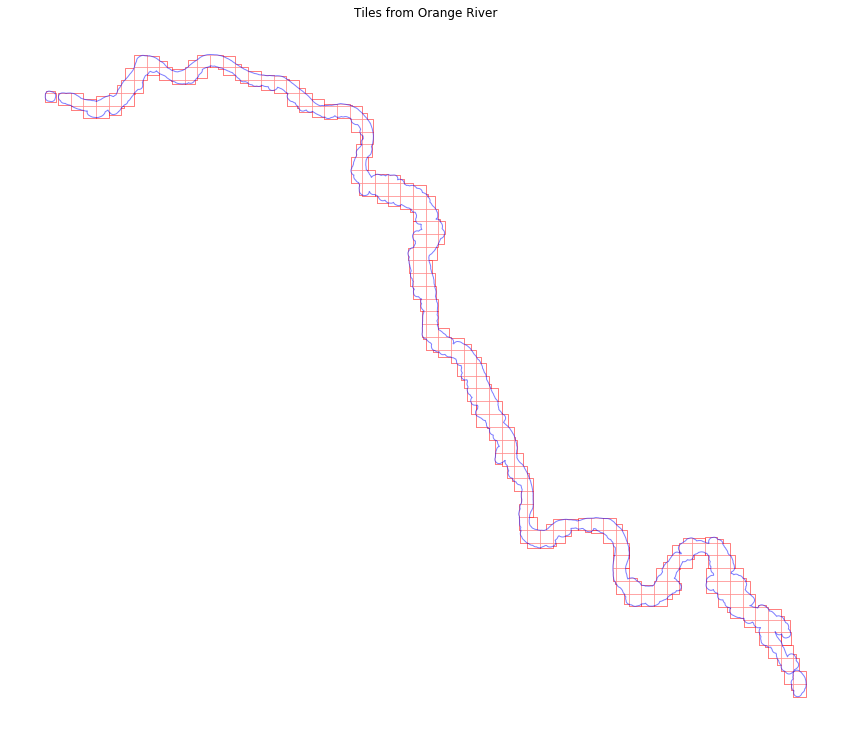

In [9]:

# figure
fig, ax = plt.subplots(figsize=(15, 15))
gdf.plot(ax=ax,facecolor='w',edgecolor='r',alpha=0.5)
orange_river_gpdf = gpd.GeoDataFrame(geometry=[orange_river])
orange_river_gpdf.plot(ax=ax, facecolor='w',edgecolor='b',alpha=0.5)
ax.set_title('Tiles from Orange River');
plt.axis('off')

### Create eo-learn task to read sentinel imagery from disk

In [9]:
# use context manager so DatasetReader and MemoryFile get cleaned up automatically
@contextmanager
def resample_raster(raster, size):
    t = raster.transform
    
    scale = size//raster.height

    # rescale the metadata
    transform = Affine(t.a / scale, t.b, t.c, t.d, t.e / scale, t.f)
    height = raster.height * scale
    width = raster.width * scale

    profile = raster.profile
    profile.update(transform=transform, driver='GTiff', height=height, width=width)

    data = raster.read( # Note changed order of indexes, arrays are band, row, col order not row, col, band
            out_shape=(raster.count, height, width, ),
            resampling=Resampling.bilinear,
        )

    with MemoryFile() as memfile:
        with memfile.open(**profile) as dataset: # Open as DatasetWriter
            dataset.write(data)
            del data

        with memfile.open() as dataset:  # Reopen as DatasetReader
            yield dataset  # Note yield not return     

class ImportFromJP2(BaseLocalIo):
   
    def __init__(self, feature, folder=None, *, timestamp_size=None, **kwargs):
      
        super().__init__(feature, folder=folder, **kwargs)

        self.timestamp_size = timestamp_size
        self.no_data_value  = np.nan

    @staticmethod
    def _get_reading_window(width, height, data_bbox, eopatch_bbox):
        """ Calculates a window in pixel coordinates for which data will be read from an image
        """
        if eopatch_bbox.crs is not data_bbox.crs:
            eopatch_bbox = eopatch_bbox.transform(data_bbox.crs)

        # The following will be in the future moved to sentinelhub-py
        data_ul_x, data_lr_y = data_bbox.lower_left
        data_lr_x, data_ul_y = data_bbox.upper_right

        res_x = abs(data_ul_x - data_lr_x) / width
        res_y = abs(data_ul_y - data_lr_y) / height

        ul_x, lr_y = eopatch_bbox.lower_left
        lr_x, ul_y = eopatch_bbox.upper_right

        # If these coordinates wouldn't be rounded here, rasterio.io.DatasetReader.read would round
        # them in the same way
        top = round((data_ul_y - ul_y) / res_y)
        left = round((ul_x - data_ul_x) / res_x)
        bottom = round((data_ul_y - lr_y) / res_y)
        right = round((lr_x - data_ul_x) / res_x)

        return (top, bottom), (left, right)
    
    def execute(self, eopatch=None, *, fn_exp='../**/*B*.jp2'):

        feature_type, feature_name = next(self.feature())
        if eopatch is None:
            eopatch = EOPatch()

            
        #get jp2 files matching filename expression
        jp2_files = [[*f.stem.split('_'),f] for f in self.folder.glob(fn_exp)]
        jp2_df = pd.DataFrame(jp2_files)
        jp2_df.columns = ['tile','date','band','filename']
        
        
        band_order = {
                        'B01':0,
                        'B02':1,
                        'B03':2,
                        'B04':3,
                        'B05':4,
                        'B06':5,
                        'B07':6,
                        'B08':7,
                        'B8A':8,
                        'B09':9,
                        'B10':10,
                        'B11':11,
                        'B12':12
                    }

        jp2_df['band_order'] = jp2_df.band.map(band_order)

        jp2_df.sort_values(by=['date','tile','band_order'],inplace=True)
        
        dates = jp2_df.date.unique()
        tiles = jp2_df.tile.unique()
        bands = list(band_order.keys())
        
        date_data_list = list() #list to hold data for each date
        #iterate through all files and add data
        for date in dates:
            #print(date)
            bands_data_list = list() #list to hold data for each band
            for band in bands:
                #print(date, band)
                tile_data_list = list()
                for tile in tiles:
                    #print(date, band, tile)
                    filename_series = jp2_df[(jp2_df.date==date)
                                     &(jp2_df.band==band)
                                     &(jp2_df.tile==tile)].filename
                    if len(filename_series) > 0:
                        filename=filename_series.values[0]
                    else: continue
                    with rasterio.open(filename) as source:
                        with resample_raster(source, size = 10980) as resampled:

                            data_bbox = BBox(resampled.bounds, CRS(resampled.crs.to_epsg()))
                            
                            if rasterio.coords.disjoint_bounds(rasterio.coords.BoundingBox(*data_bbox), 
                                                               rasterio.coords.BoundingBox(*eopatch.bbox)):
                                continue

                            reading_window = self._get_reading_window(
                                resampled.width, resampled.height, data_bbox, eopatch.bbox)

                            data = resampled.read(window=reading_window, boundless=True, 
                                                  fill_value=self.no_data_value)
                            
                            if self.image_dtype is not None:
                                data = data.astype(self.image_dtype)
                                
                            tile_data_list.append(data)

                #Choose the values from the non-zero tile or average the two sets of non-zero value
                
                if len(tile_data_list) > 1:
                    merged_tile_data = np.where((tile_data_list[0]!=0) & (tile_data_list[1]!=0),
                                            (tile_data_list[0]+tile_data_list[1])/2,
                                            np.where(tile_data_list[0]==0, tile_data_list[1], tile_data_list[0])
                                           )
                else:
                    merged_tile_data = tile_data_list[0]

                bands_data_list.append(merged_tile_data.squeeze())
                    
            date_data_list.append(np.stack(bands_data_list,axis=-1))
        
        data = np.stack(date_data_list,axis=0)
        eopatch[feature_type][feature_name] = data/10000
        eopatch.timestamp = dates.tolist()
        
        meta_info= {
            'service_type': 'wcs',
            'size_x': '10m',
            'size_y': '10m'
          }
        
        eopatch.meta_info = meta_info

        return eopatch

### Create more helper tasks

In [10]:
class SentinelHubValidData:
    """
    Combine Sen2Cor's classification map with `IS_DATA` to define a `VALID_DATA_SH` mask
    The SentinelHub's cloud mask is asumed to be found in eopatch.mask['CLM']
    """
    def __call__(self, eopatch):        
        return np.logical_not(eopatch.mask['CLM'].astype(np.bool))
    
class NormalizedDifferenceIndex(EOTask):   
    """
    The tasks calculates user defined Normalised Difference Index (NDI) between two bands A and B as:
    NDI = (A-B)/(A+B).
    """
    def __init__(self, feature_name, band_a, band_b):
        self.feature_name = feature_name
        self.band_a_fetaure_name = band_a.split('/')[0]
        self.band_b_fetaure_name = band_b.split('/')[0]
        self.band_a_fetaure_idx = int(band_a.split('/')[-1])
        self.band_b_fetaure_idx = int(band_b.split('/')[-1])
        
    def execute(self, eopatch):
        band_a = eopatch.data[self.band_a_fetaure_name][..., self.band_a_fetaure_idx]
        band_b = eopatch.data[self.band_b_fetaure_name][..., self.band_b_fetaure_idx]
        
        ndi = (band_a - band_b) / (band_a  + band_b)
        
        eopatch.add_feature(FeatureType.DATA, self.feature_name, ndi[..., np.newaxis])
        
        return eopatch

    
class EuclideanNorm(EOTask):   
    """
    The tasks calculates Euclidian Norm of all bands within an array:
    norm = sqrt(sum_i Bi**2),
    where Bi are the individual bands within user-specified feature array.
    """
    def __init__(self, feature_name, in_feature_name):
        self.feature_name = feature_name
        self.in_feature_name = in_feature_name
    
    def execute(self, eopatch):
        arr = eopatch.data[self.in_feature_name]
        norm = np.sqrt(np.sum(arr**2, axis=-1))
        
        eopatch.add_feature(FeatureType.DATA, self.feature_name, norm[..., np.newaxis])
        return eopatch

### Create workflow

In [11]:
### TASK FOR BAND DATA
# add a request for B(B02), G(B03), R(B04), NIR (B08), SWIR1(B11), SWIR2(B12) 
# from default layer 'ALL_BANDS' at 10m resolution

add_data = ImportFromJP2(feature=[
    (FeatureType.DATA, 'BANDS')
], folder=sentinel_path)

# TASK FOR CLOUD INFO
# cloud detection is performed at 80m resolution 
# and the resulting cloud probability map and mask 
# are scaled to EOPatch's resolution
cloud_classifier = get_s2_pixel_cloud_detector(average_over=2, dilation_size=1, all_bands=True)
add_clm = AddCloudMaskTask(cloud_classifier, 'BANDS', cm_size_y='80m', cm_size_x='80m', 
                           cmask_feature='CLM', # cloud mask name
                           cprobs_feature='CLP' # cloud prob. map name
                          )

# TASKS FOR CALCULATING NEW FEATURES
# NDVI: (B08 - B04)/(B08 + B04) # we use 8a
# NDWI: (B03 - B08)/(B03 + B08) # we use 8a
# NORM: sqrt(B02^2 + B03^2 + B04^2 + B08^2 + B11^2 + B12^2)
ndvi = NormalizedDifferenceIndex('NDVI', 'BANDS/8', 'BANDS/3')
ndwi = NormalizedDifferenceIndex('NDWI', 'BANDS/2', 'BANDS/8')
norm = EuclideanNorm('NORM','BANDS')

# TASK FOR VALID MASK
# validate pixels using SentinelHub's cloud detection mask and region of acquisition 
add_sh_valmask = AddValidDataMaskTask(SentinelHubValidData(), 
                                      'IS_VALID' # name of output mask
                                     )

# TASK FOR SAVING TO OUTPUT
path_out = output_path/'<CHANGE ME>/'
if not os.path.isdir(path_out):
    os.makedirs(path_out)
save = SaveToDisk(path_out, overwrite_permission=OverwritePermission.OVERWRITE_PATCH)

In [12]:
### TASK for rasterizing target classes

class LULC(Enum):
    NO_DATA        = (0,  'No Data',          'black')
    COTTON         = (1,  'Cotton',           'xkcd:lime')
    DATES          = (2,  'Dates',            'xkcd:darkgreen')
    GRASS          = (3,  'Grass',            'orange')
    LUCERN         = (4,  'Lucern',           'xkcd:tan')
    MAIZE          = (5,  'Maize',            'xkcd:azure')
    PECAN          = (6,  'Pecan',            'xkcd:lightblue')
    VACANT         = (7,  'Vacant',           'xkcd:beige')
    VINEYARD       = (8,  'Vineyard',         'crimson')
    VINEYARD_PECAN = (9,  'Vineyard & Pecan', 'xkcd:lavender')
    
    def __init__(self, val1, val2, val3):
        self.id = val1
        self.class_name = val2
        self.color = val3
        
# Reference colormap things
lulc_cmap = mpl.colors.ListedColormap([entry.color for entry in LULC])
lulc_norm = mpl.colors.BoundaryNorm(np.arange(-0.5, 11, 1), lulc_cmap.N)

land_cover_path = data_path/'train'

land_cover_data = gpd.read_file(land_cover_path)

land_cover_data.dropna(inplace=True)

land_cover_data.to_crs({'init': 'EPSG:32734'},inplace=True)

land_cover_data['Crop_Id_Ne'] = land_cover_data.Crop_Id_Ne.astype('int')

rasterization_task = VectorToRaster(land_cover_data, (FeatureType.MASK_TIMELESS, 'LULC'),
                                    values_column='Crop_Id_Ne', raster_shape=(FeatureType.MASK, 'IS_VALID'),
                                    raster_dtype=np.uint8)

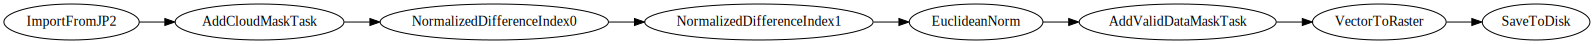

In [13]:
# Define the workflow
workflow = LinearWorkflow(
    add_data,
    add_clm,
    ndvi,
    ndwi,
    norm,
    add_sh_valmask,
    rasterization_task,
    save
)

# Let's visualize it
workflow.dependency_graph()

In [15]:
# Execute the workflow
time_interval = ['2017-01-01', '2017-08-20'] # time interval for the SH request

# define additional parameters of the workflow
execution_args = []
for idx, bbox in enumerate(bbox_list[patchIDs]):
    execution_args.append({
        add_data:{'eopatch': EOPatch(bbox=bbox)},
        save: {'eopatch_folder': 'eopatch_{}'.format(idx)}
    });
1

1

In [16]:
%%time
# executor = EOExecutor(workflow, execution_args, save_logs=True)
# executor.run(workers=1, multiprocess=False)

# executor.make_report()

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 5.96 µs


In [21]:
patch_path = output_path/'eopatches-large/'

In [23]:
eopatch = EOPatch.load(patch_path/'eopatch_0/')
eopatch

EOPatch(
  data: {
    FEATURES: numpy.ndarray(shape=(8, 1353, 1335, 16), dtype=float64)
  }
  mask: {}
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LULC: numpy.ndarray(shape=(1353, 1335, 1), dtype=uint8)
    TEST_FIELD_ID: numpy.ndarray(shape=(1353, 1335, 1), dtype=uint16)
    TRAIN_FIELD_ID: numpy.ndarray(shape=(1353, 1335, 1), dtype=uint16)
  }
  scalar_timeless: {}
  label_timeless: {}
  vector_timeless: {}
  meta_info: {}
  bbox: BBox(((535129.8381333639, 6846878.021770692), (548483.7166625774, 6860414.749511358)), crs=EPSG:32734)
  timestamp: [datetime.datetime(2017, 1, 1, 0, 0), ..., datetime.datetime(2017, 7, 23, 0, 0)], length=8
)

In [ ]:
# Draw the RGB image

indexes = [[0,1,4],
               [3,7],
               [2,6], 
                 [5,9,11],
                   [8,10]]

places  = [[1,  2,  3],
                   [9 , 10],
                   [15, 16], 
                       [22 , 23, 24],
                            [29, 30]]

fig = plt.figure(figsize=(50*6/5, 50))
k=0

for i, (idxs, plc) in enumerate(zip(indexes,places)):
    for j, (idx,p) in enumerate(zip(idxs,plc)):
        k=k+1
        eopatch = EOPatch.load('{}/eopatch_{}'.format(patch_path, idx), lazy_loading=True)
        ax = plt.subplot(5, 6, p)
        plt.imshow(np.clip(eopatch.data['BANDS'][0][..., [2, 1, 0]] * 3.5, 0, 1))
        plt.xticks([])
        plt.yticks([])
        ax.set_aspect("auto")
        del eopatch

    fig.subplots_adjust(wspace=0, hspace=0)

In [ ]:
# Draw the RGB image

indexes = [[0,1,4],
               [3,7],
               [2,6], 
                 [5,9,11],
                   [8,10]]

places  = [[1,  2,  3],
                   [9,  10],
                   [15, 16], 
                       [22, 23, 24],
                            [29, 30]]

fig, axes = plt.subplots(figsize=(50*6/5, 50), nrows=5, ncols=6)
k=0

for i, (idxs, plc) in enumerate(zip(indexes,places)):
    for j, (idx,p) in enumerate(zip(idxs,plc)):
        k=k+1
        ax = plt.subplot(5, 6, p)
        eopatch = EOPatch.load('{}/eopatch_{}'.format(patch_path, idx), lazy_loading=True)
        im = ax.imshow(eopatch.mask_timeless['LULC'].squeeze(), cmap=lulc_cmap, norm=lulc_norm)
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_aspect("auto")
        del eopatch
    fig.subplots_adjust(wspace=0, hspace=0)

# cb = fig.colorbar(im, ax=axes
#                   , orientation='horizontal', pad=0.01, aspect=100)
# cb.ax.tick_params(labelsize=20) 
# cb.set_ticks([entry.id for entry in LULC])
# cb.ax.set_xticklabels([entry.class_name for entry in LULC], rotation=45, fontsize=15)
# plt.show()

In [ ]:
# Draw the RGB image

indexes = [[0,1,4],
               [3,7],
               [2,6], 
                 [5,9,11],
                   [8,10]]

places  = [[1,  2,  3],
                   [9 , 10],
                   [15, 16], 
                       [22 , 23, 24],
                            [29, 30]]
path_out = './eopatches-large/'

fig = plt.figure(figsize=(50*6/5, 50))
k=0

for i, (idxs, plc) in enumerate(zip(indexes,places)):
    for j, (idx,p) in enumerate(zip(idxs,plc)):
        k=k+1
        eopatch = EOPatch.load('{}/eopatch_{}'.format(path_out, idx), lazy_loading=True)
        ax = plt.subplot(5, 6, p)
        
        ndvi = eopatch.data['NDVI']
        mask = eopatch.mask['IS_VALID']
        ndvi[~mask] = np.nan
        ndvi_mean = np.nanmean(ndvi, axis=0).squeeze()
        im = ax.imshow(ndvi_mean, vmin=0, vmax=0.8, cmap=plt.get_cmap('YlGn'))
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_aspect("auto")
        del eopatch

fig.subplots_adjust(wspace=0, hspace=0)

cb = fig.colorbar(im, ax=axes.ravel().tolist(), orientation='horizontal', pad=0.01, aspect=100)
cb.ax.tick_params(labelsize=20) 
plt.show()

### Interpolate and Extrapolate

In [26]:
%matplotlib inline

indexes = [[0,1,4],
               [3,7],
               [2,6], 
                 [5,9,11],
                   [8,10]]

places  = [[1,  2,  3],
                   [9 , 10],
                   [15, 16], 
                       [22 , 23, 24],
                            [29, 30]]

patchIDs = [0,1,2,3,4,5,6,7,8,9,10,11]

patches_path = output_path/'eopatches-large/'

data_path = Path('../data')
sentinel_path = data_path/'sentinel'

In [27]:
class ConcatenateData(EOTask):
    """ Task to concatenate data arrays along the last dimension
    """
    def __init__(self, feature_name, feature_names_to_concatenate):
        self.feature_name = feature_name
        self.feature_names_to_concatenate = feature_names_to_concatenate

    def execute(self, eopatch):
        arrays = [eopatch.data[name] for name in self.feature_names_to_concatenate]

        eopatch.add_feature(FeatureType.DATA, self.feature_name, 
                            np.concatenate(arrays, axis=-1))

        return eopatch
    
class ValidDataFractionPredicate:
    """ Predicate that defines if a frame from EOPatch's time-series is valid or not. 
    Frame is valid, if the 
    valid data fraction is above the specified threshold.
    """
    def __init__(self, threshold):
        self.threshold = threshold
        
    def __call__(self, array):
        coverage = np.sum(array.astype(np.uint8)) / np.prod(array.shape)
        return coverage > self.threshold

In [ ]:
# TASK TO LOAD EXISTING EOPATCHES
load = LoadFromDisk(patch_path)

# TASK FOR CONCATENATION
concatenate = ConcatenateData('FEATURES', ['BANDS', 'NDVI', 'NDWI', 'NORM'])

# TASK FOR FILTERING OUT TOO CLOUDY SCENES
# keep frames with > 80 % valid coverage
valid_data_predicate = ValidDataFractionPredicate(0.8)
filter_task = SimpleFilterTask((FeatureType.MASK, 'IS_VALID'), valid_data_predicate)

# TASK FOR LINEAR INTERPOLATION
# linear interpolation of full time-series and date resampling

resampled_range = ('2017-01-01', '2017-8-20', 29)
linear_interp = LinearInterpolation(
    'FEATURES', # name of field to interpolate
    mask_feature=(FeatureType.MASK, 'IS_VALID'), # mask to be used in interpolation
    copy_features=[(FeatureType.MASK_TIMELESS, 'LULC'),
                   (FeatureType.MASK_TIMELESS, 'TEST_FIELD_ID'),
                  (FeatureType.MASK_TIMELESS, 'TRAIN_FIELD_ID')], # features to keep\
    resample_range=resampled_range, # set the resampling range
    bounds_error=False # extrapolate with NaN's
)

# TASK FOR EROSION
# erode each class of the reference map
erosion = ErosionTask(mask_feature=(FeatureType.MASK_TIMELESS,'LULC','LULC_ERODED'), disk_radius=1)

fill_extrapolate = ValueFilloutTask(feature='FEATURES', operations='fb', value=np.nan, axis=0)

haralick = HaralickTask(feature = (FeatureType.DATA, 'bands'), 
                        texture_feature = 'sum_entropy')

path_out_features = output_path/'eopatches_large_features/'
if not os.path.isdir(path_out_sampled):
    os.makedirs(path_out_sampled)
save = SaveToDisk(path_out_features, overwrite_permission=OverwritePermission.OVERWRITE_PATCH)

In [ ]:
land_cover_path = data_path/'test'

land_cover_data = gpd.read_file(land_cover_path)

land_cover_data.to_crs({'init': 'EPSG:32734'},inplace=True)

land_cover_data['Field_Id'] = land_cover_data.Field_Id.astype(np.uint16)

test_field_id_raster = VectorToRaster(land_cover_data, (FeatureType.MASK_TIMELESS, 'TEST_FIELD_ID'),
                                    values_column='Field_Id', raster_shape=(FeatureType.MASK, 'IS_VALID'),
                                    raster_dtype=np.uint16)

land_cover_path = data_path/'train'

land_cover_data = gpd.read_file(land_cover_path)

land_cover_data.dropna(inplace=True)

land_cover_data.to_crs({'init': 'EPSG:32734'},inplace=True)

land_cover_data['Field_Id'] = land_cover_data.Field_Id.astype(np.uint16)

train_field_id_raster = VectorToRaster(land_cover_data, (FeatureType.MASK_TIMELESS, 'TRAIN_FIELD_ID'),
                                    values_column='Field_Id', raster_shape=(FeatureType.MASK, 'IS_VALID'),
                                    raster_dtype=np.uint16)

In [ ]:
# Define the workflow
workflow = LinearWorkflow(
    load,
    test_field_id_raster,
    train_field_id_raster,
    concatenate,
    filter_task,
    linear_interp,
    fill_extrapolate,
    save
)

In [ ]:
%%time
   
execution_args = []
for idx in range(len(patchIDs)):
    execution_args.append({
        load: {'eopatch_folder': 'eopatch_{}'.format(idx)},
        save: {'eopatch_folder': 'eopatch_{}'.format(idx)}
    })
    
executor = EOExecutor(workflow, execution_args, save_logs=True)
executor.run(workers=5, multiprocess=True)

executor.make_report()